# SHRED for ROMs: interpolation - contour plotting

This notebook serves as plotting routine for the Full Order reconstruction, using *pyvista*.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams
import pickle
from pyforce.tools.functions_list import FunctionsList

import vtk
import pyvista as pv
import dolfinx

# Comment this line if you don't want to use the SSH connection
pv.start_xvfb()

# Uncomment only with latex installed on your machine
# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "serif"
# })

# rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

var_names, is_vector, times = pickle.load(open('msfr_uloff.set', 'rb'))

path_svd = './OfflineSVD/'
u_total = pickle.load(open(path_svd+'u_total.svd', 'rb'))
v_total = pickle.load(open(path_svd+'v_total.svd', 'rb'))
s_total = pickle.load(open(path_svd+'s_total.svd', 'rb'))

var_names = pickle.load(open(path_svd+"var.names", 'rb'))
rescaling_snaps = pickle.load(open(path_svd+"rescaling.svd", 'rb'))
Nmodes = pickle.load(open(path_svd+"Nmodes.svd", 'rb'))

incore_measure = False

if incore_measure:
    path_test = './Test_results/InCore/'
    measurements = pickle.load(open(path_svd+'measurements_incore.data', 'rb'))
else:
    path_test = './Test_results/'
    measurements = pickle.load(open(path_svd+'measurements_3.data', 'rb'))
    # measurements = pickle.load(open(path_svd+'measurements_10.data', 'rb'))
    
# Load the results
test_recons, test_ground_truth, _ = pickle.load(open(path_test+'test.results', 'rb'))

binned_stats = pickle.load(open(path_test+'binned.statitics', 'rb'))

if incore_measure:
    path_shred = './SHRED/InCore/'
else:
    path_shred = './SHRED/'
test_datasets = pickle.load(open(path_shred+'datasets.test', 'rb'))

new_t = np.linspace(min(times), max(times), len(measurements['noisy_output'][0,:,0]))

Let us define the tex variables

In [3]:
energy_groups = 6
tex_var_names = [r'\phi_'+str(g+1) for g in range(energy_groups)]

prec_groups = 8
tex_var_names.extend([r'c_'+str(g+1) for g in range(prec_groups)])

dec_groups = 3
tex_var_names.extend([r'd_'+str(g+1) for g in range(dec_groups)])

tex_var_names.extend(['T', 'p', r'\mathbf{u}'])

assert len(tex_var_names) == len(var_names)

Let us import the mesh and let us define the functional spaces

In [4]:
from mesh import *
from dolfinx.fem import Function, FunctionSpace, locate_dofs_topological
import ufl
from IPython.display import clear_output

domain, ct, ft = evol_mesh()

fun_spaces = [FunctionSpace(domain, ('Lagrange', 1))]*(len(var_names)-1)
fun_spaces.append(FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1)))

measured_field = 0

clear_output()

reflector_mark = 20
refl_tags = locate_dofs_topological(fun_spaces[measured_field], ct.dim, ct.find(reflector_mark))
Nh = fun_spaces[measured_field].tabulate_dof_coordinates().shape[0]

Let us define the function to map from *dolfinx.fem.dolfinx* to grid for *pyvista*

In [5]:
def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.25, tolerance=0.02)
        
    return warped, values

def grids(fun: dolfinx.fem.Function, log_plot = False):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    if log_plot:
        u_grid.point_data['fun'] = np.log10(fun.x.array[:].real)
    else:
        u_grid.point_data['fun'] = fun.x.array[:].real

    u_grid.set_active_scalars('fun')
    return u_grid

Now let us make some plot of the full order fields with the sensors

In [9]:
# from pyforce.tools.write_read import ImportH5

# field_i = measured_field
# snaps_to_plot = ImportH5(fun_spaces[field_i], './dolfinx_data/'+var_names[field_i], var_names[field_i], verbose=False)[0]

# for mu_to_plot in np.arange(99, len(snaps_to_plot), 100):
#     cmap = cm.Spectral_r

#     resolution = [1200, 1200]
#     plotter = pv.Plotter(shape=(1, 1), off_screen=False, border=False, window_size=resolution)
        
#     lab_fontsize = 35
#     title_fontsize = 60
#     zoom = 1.025

#     dict_cb = dict(title = ' ', width = 0.5,
#                     title_font_size=title_fontsize,
#                     label_font_size=lab_fontsize,
#                     color='k',
#                     position_x=0.25, position_y=0.89,
#                     shadow=False) 
#     dict_cb['n_labels'] = 0

#     clim_scale = .01

#     plotter.subplot(0,0)
#     clim = [0,  max(snaps_to_plot(99)) * (1+clim_scale)]
#     dict_cb['title'] = r'FOM - $'+tex_var_names[field_i]+r'(\mathbf{x}; t)$'
#     plotter.add_mesh(grids(snaps_to_plot.map(mu_to_plot)), cmap = cmap, clim = clim, show_edges=False, scalar_bar_args=dict_cb)

#     plotter.add_point_labels(   measurements['mesh'][measurements['location'][:,0]], 
#                                 np.arange(1,4,1), italic=False,
#                                 font_size=40,
#                                 point_color='black',
#                                 shape_color='white',
#                                 shape_opacity=0.85,
#                                 point_size=25,
#                                 render_points_as_spheres=True,
#                                 always_visible=True,
#                                 shadow=False)

#     plotter.view_xy()
#     plotter.camera.zoom(zoom)

#     plotter.screenshot('FOM_'+var_names[field_i]+'_'+str(mu_to_plot)+'.png', transparent_background = True,  window_size=resolution)
#     plotter.close()

At first, let us reconstruct the state for any test value of time

In [6]:
import os
from pyforce.tools.backends import LoopProgress

field_i = 19
path_fig = path_test+'Fig_std/'+var_names[field_i]+'/'
if not os.path.exists(path_fig):
    os.makedirs(path_fig)

v_truth = list()
v_shred = list()

bar = LoopProgress('Reconstructing - '+var_names[field_i], final = len(test_ground_truth))
for kk in range(len(test_ground_truth)):

    u_ = u_total[var_names[field_i]]
    s_ = np.diag(s_total[var_names[field_i]])

    # FOM
    v_truth.append(test_ground_truth[kk][:,3 + sum(Nmodes[:field_i]) : 3 + sum(Nmodes[:field_i+1])])
    
    # SHRED
    v_shred.append(test_recons[kk][:,3 + sum(Nmodes[:field_i]) : 3 + sum(Nmodes[:field_i+1])])
    
    bar.update(1)

Reconstructing - U: 30.000 / 30.00 - 0.000 s/it


Let us compute the mean and the standard deviation of FOM and SHRED latent dynamics

In [7]:
import pandas as pd

plot_fom_binned_stats   = list()
plot_shred_binned_stats = list()

# Determine time bins
bin_width = 0.1

bar = LoopProgress('Evaluate Mean&Std', final = v_shred[0].shape[1])

for mesh_idx in range(v_shred[0].shape[1]):
    
    # FOM
    data = pd.DataFrame({
        'time': np.hstack([new_t[_test['idx']] for _test in test_datasets]),
        'fom': np.hstack([_test[:, mesh_idx] for _test in v_truth]),
    })
    bins = np.arange(0, max(data['time']) + bin_width, bin_width)
    data['bin'] = pd.cut(data['time'], bins, right=False)
    binned_stats_tmp = data.groupby('bin', observed=True)['fom'].agg(['mean', 'std']).reset_index()
    binned_stats_tmp['time'] = bins[:-1] + bin_width / 2

    plot_fom_binned_stats.append(binned_stats_tmp.dropna())
    
    # SHRED
    data = pd.DataFrame({
        'time': np.hstack([new_t[_test['idx']] for _test in test_datasets]),
        'shred': np.hstack([_test[:, mesh_idx] for _test in v_shred]),
    })
    bins = np.arange(0, max(data['time']) + bin_width, bin_width)
    data['bin'] = pd.cut(data['time'], bins, right=False)
    binned_stats_tmp = data.groupby('bin', observed=True)['shred'].agg(['mean', 'std']).reset_index()
    binned_stats_tmp['time'] = bins[:-1] + bin_width / 2

    plot_shred_binned_stats.append(binned_stats_tmp.dropna())
    
    bar.update(1)
    
fom_v_mean = np.array([df['mean'].to_numpy() for df in plot_fom_binned_stats])
fom_v_std  = np.array([df['std'].to_numpy()  for df in plot_fom_binned_stats])

shred_v_mean = np.array([df['mean'].to_numpy() for df in plot_shred_binned_stats])
shred_v_std  = np.array([df['std'].to_numpy()  for df in plot_shred_binned_stats])

fom = (u_ @ s_ @ fom_v_mean) * rescaling_snaps[field_i]
prediction = (u_ @ s_ @ shred_v_mean) * rescaling_snaps[field_i] 
std_dev_prediction = (u_ @ s_ @ shred_v_std) * rescaling_snaps[field_i] 

fom_list = FunctionsList(fun_spaces[field_i])
for mu in range(fom.shape[1]):
    fom_list.append(fom[:,mu])
    
pred_list = FunctionsList(fun_spaces[field_i])
for mu in range(prediction.shape[1]):
    pred_list.append(prediction[:,mu])
    
std_pred_list = FunctionsList(fun_spaces[field_i])
for mu in range(std_dev_prediction.shape[1]):
    std_pred_list.append(std_dev_prediction[:,mu])
    
time_bins = plot_shred_binned_stats[0]['time'].to_numpy()

Evaluate Mean&Std: 10.000 / 10.00 - 0.019 s/it


Let's plot everything using `pyvista`, here's the function to do so

In [14]:
def Plot_SHRED_std_reconstruction(  fom: FunctionsList, shred: FunctionsList,
                                    std_dev: FunctionsList,
                                    tex_var: str, 
                                    time_to_plot: int, title : str,
                                    filename: str, clims : list = None,
                                    colormaps = None, colormaps_residual = None,
                                    log_plot = False):
    
    nrows = 1
    ncols = 4
    
    if colormaps is None:
        _colormaps = cm.jet
        _colormaps_residual = cm.plasma_r
    else:
        _colormaps = colormaps
        _colormaps_residual = colormaps_residual
    
    resolution = [900 * ncols, 1200 * nrows]
    plotter = pv.Plotter(shape=(nrows, ncols), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 30
    title_fontsize = 45
    zoom = 1.35
    
    dict_cb = dict( width = 0.65, height = 0.15,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=2,
                    color = 'k',
                    position_x=0.175, position_y=0.8785,
                    shadow=False) 
    
    # FOM
    plotter.subplot(0,0)
    
    if fom.fun_space.num_sub_spaces > 0:
        is_vector = True
        warped_, _ = vector_grids(fom.map(time_to_plot), mag_plot=True, varname=tex_var)
    else:
        is_vector = False
        warped_ = grids(fom.map(time_to_plot), log_plot = log_plot)
    
    if clims is None:
        _clim = [min(fom(time_to_plot)), max(fom(time_to_plot))]
    else:
        _clim = clims

    dict_cb['title'] = 'FOM - $'+tex_var+'$'
    plotter.add_mesh(warped_, clim=_clim, cmap=_colormaps, show_edges=False, scalar_bar_args=dict_cb)
    
    if is_vector:
        warped_, _ = vector_grids(fom.map(time_to_plot), mag_plot=False, varname=tex_var)
        plotter.add_mesh(warped_, clim=_clim, color='black', show_edges=False, scalar_bar_args=dict_cb)    
    
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    plotter.add_text(title, color= 'k', position=[50, 50], font_size=35)
    
    # SHRED
    plotter.subplot(0,1)
    
    if shred.fun_space.num_sub_spaces > 0:
        assert is_vector is True
        warped_, _ = vector_grids(shred.map(time_to_plot), mag_plot=True, varname=tex_var)
    else:
        assert is_vector is False
        warped_ = grids(shred.map(time_to_plot), log_plot = log_plot)
    
    dict_cb['title'] = 'SHRED - $'+tex_var+'$'
    plotter.add_mesh(warped_, clim=_clim, cmap=_colormaps, show_edges=False, scalar_bar_args=dict_cb)
    if is_vector:
        warped_, _ = vector_grids(shred.map(time_to_plot), mag_plot=False, varname=tex_var)
        plotter.add_mesh(warped_, clim=_clim, color='black', show_edges=False, scalar_bar_args=dict_cb)    
    
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    # Residual
    plotter.subplot(0,2)
    residual = Function(fom.fun_space)
    residual.x.array[:] = np.abs(fom(time_to_plot) - shred(time_to_plot))
    
    if is_vector:
        warped_, _ = vector_grids(residual, mag_plot=True, varname=tex_var)
    else:
        warped_ = grids(residual)
    
    res_clim = [0, max(residual.x.array)]
    dict_cb['title'] = 'Residual - $'+tex_var+'$'
    plotter.add_mesh(warped_, clim=res_clim, cmap=_colormaps_residual, show_edges=False, scalar_bar_args=dict_cb)
    
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    # Standard Deviation
    plotter.subplot(0,3)
    
    if is_vector:
        warped_, _ = vector_grids(std_dev.map(time_to_plot), mag_plot=True, varname=tex_var)
    else:
        warped_ = grids(std_dev.map(time_to_plot))
    
    std_clim = [min(std_dev(time_to_plot)), max(std_dev(time_to_plot))]
    dict_cb['title'] = 'Standard Deviation - $'+tex_var+'$'
    plotter.add_mesh(warped_, clim=std_clim, cmap=_colormaps_residual, show_edges=False, scalar_bar_args=dict_cb)
    
    plotter.view_xy()
    plotter.camera.zoom(zoom)
    
    plotter.set_background('white', top='white')
        
    ## Save figure
    if filename is not None:
        plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
        plotter.close()
    else:
        plotter.show()

For some specific time instants the plot is generated

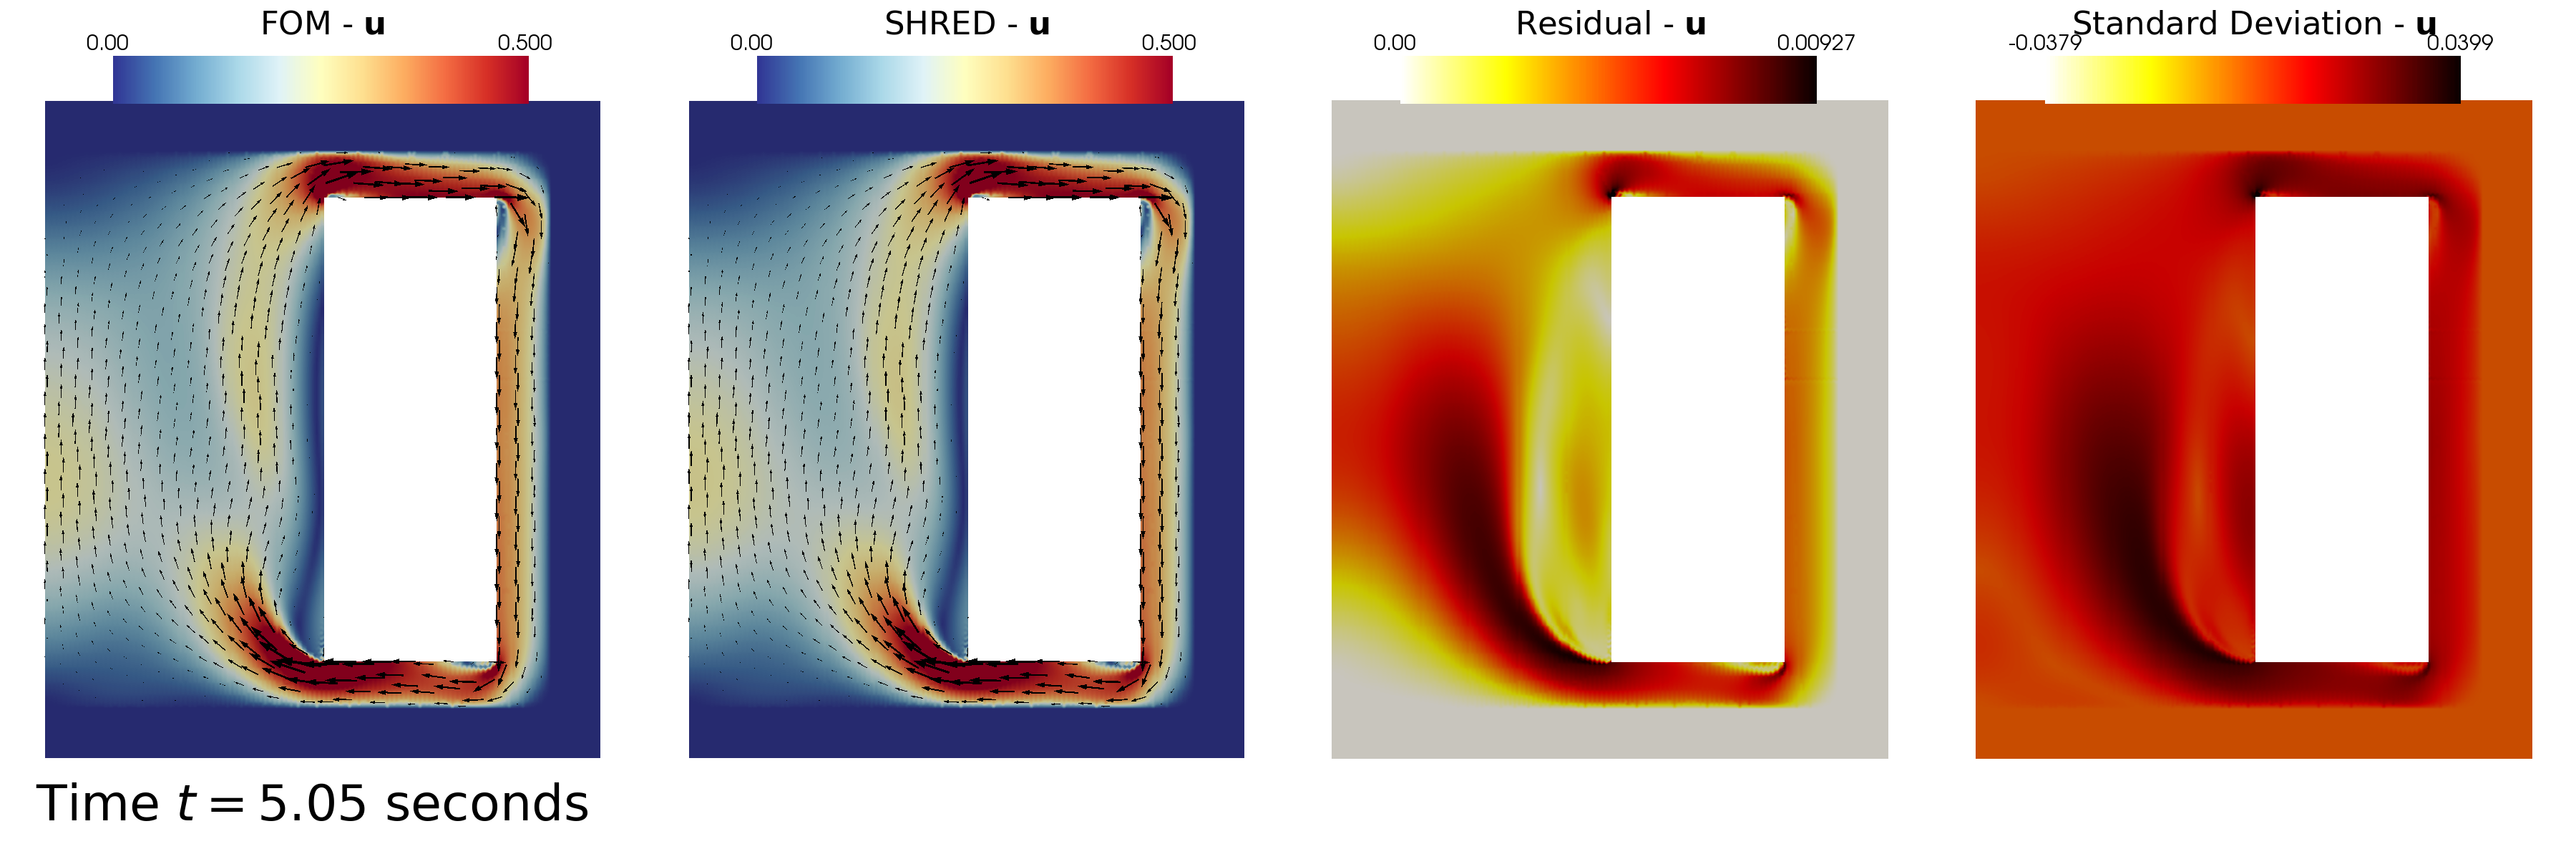

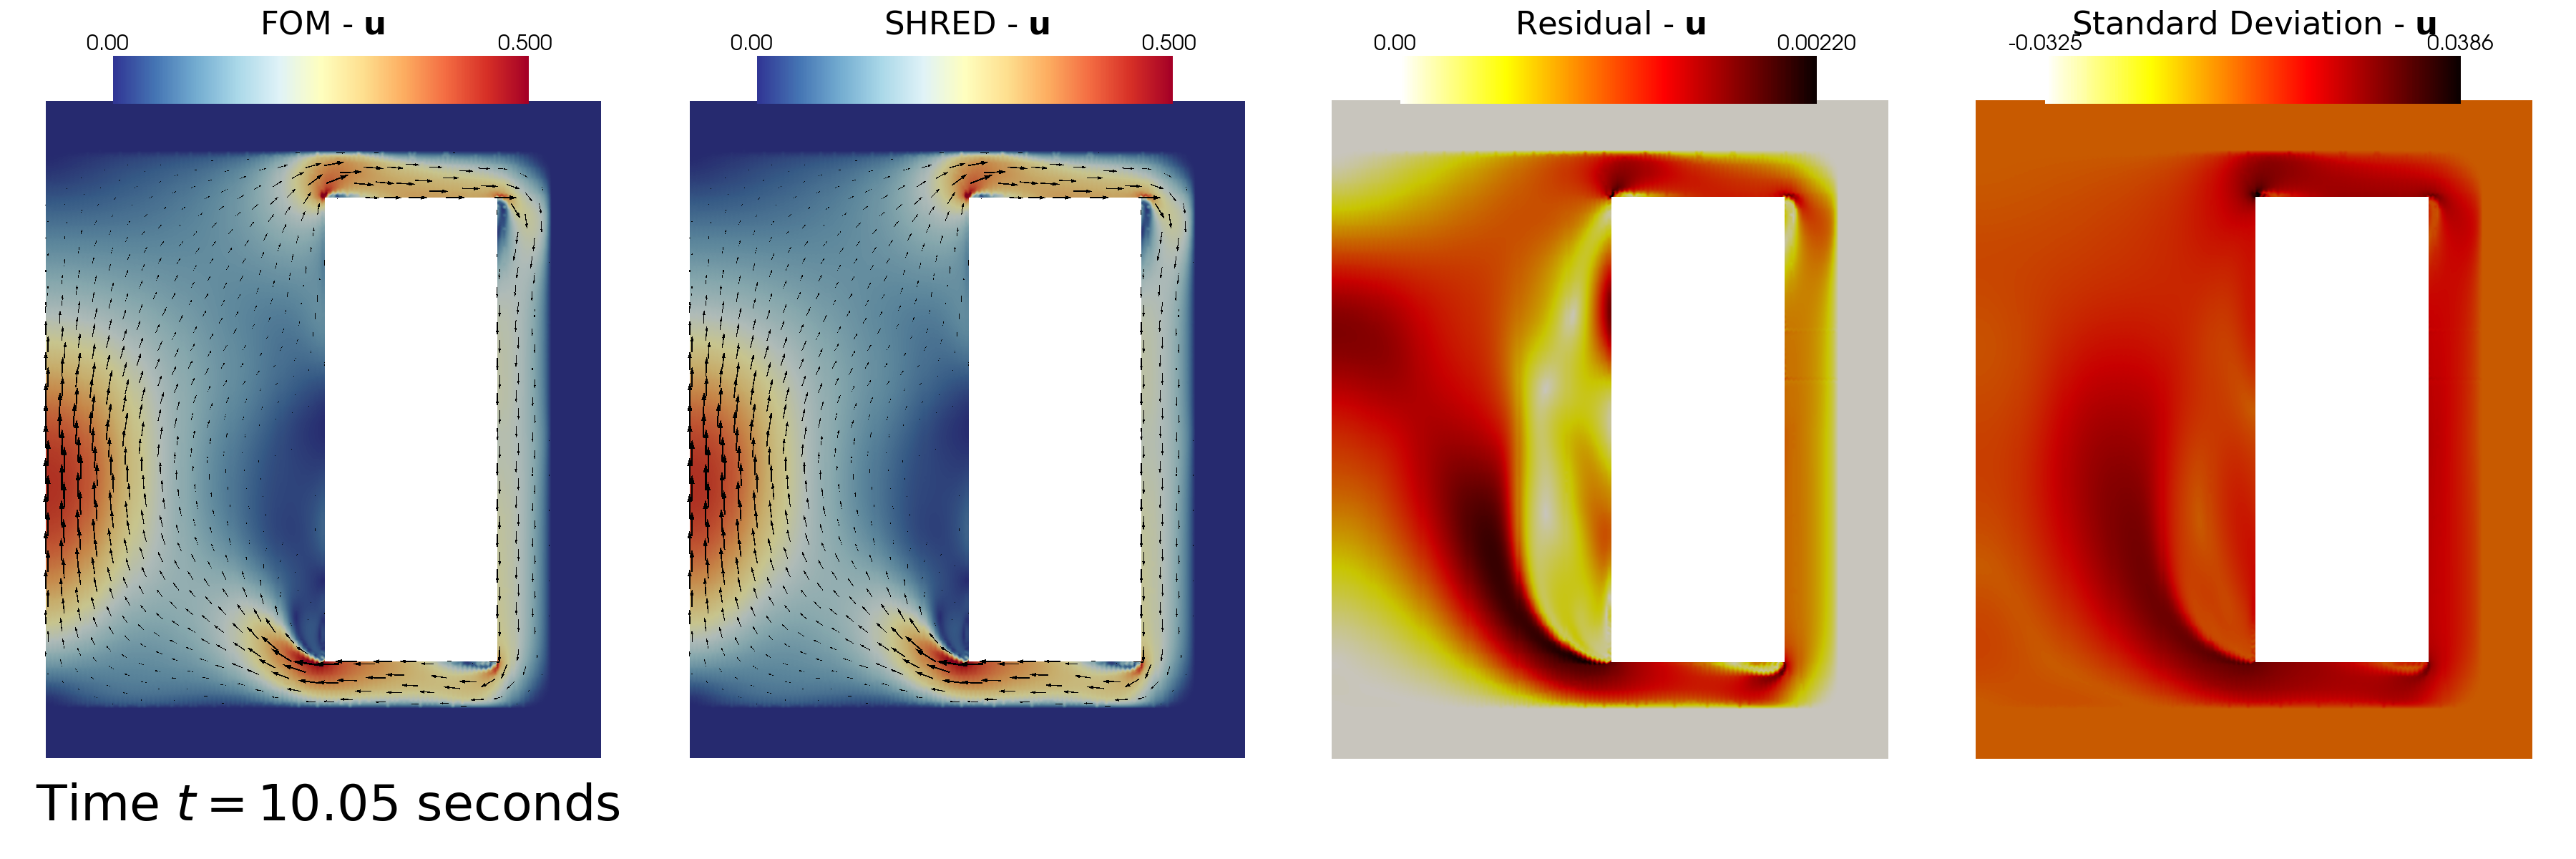

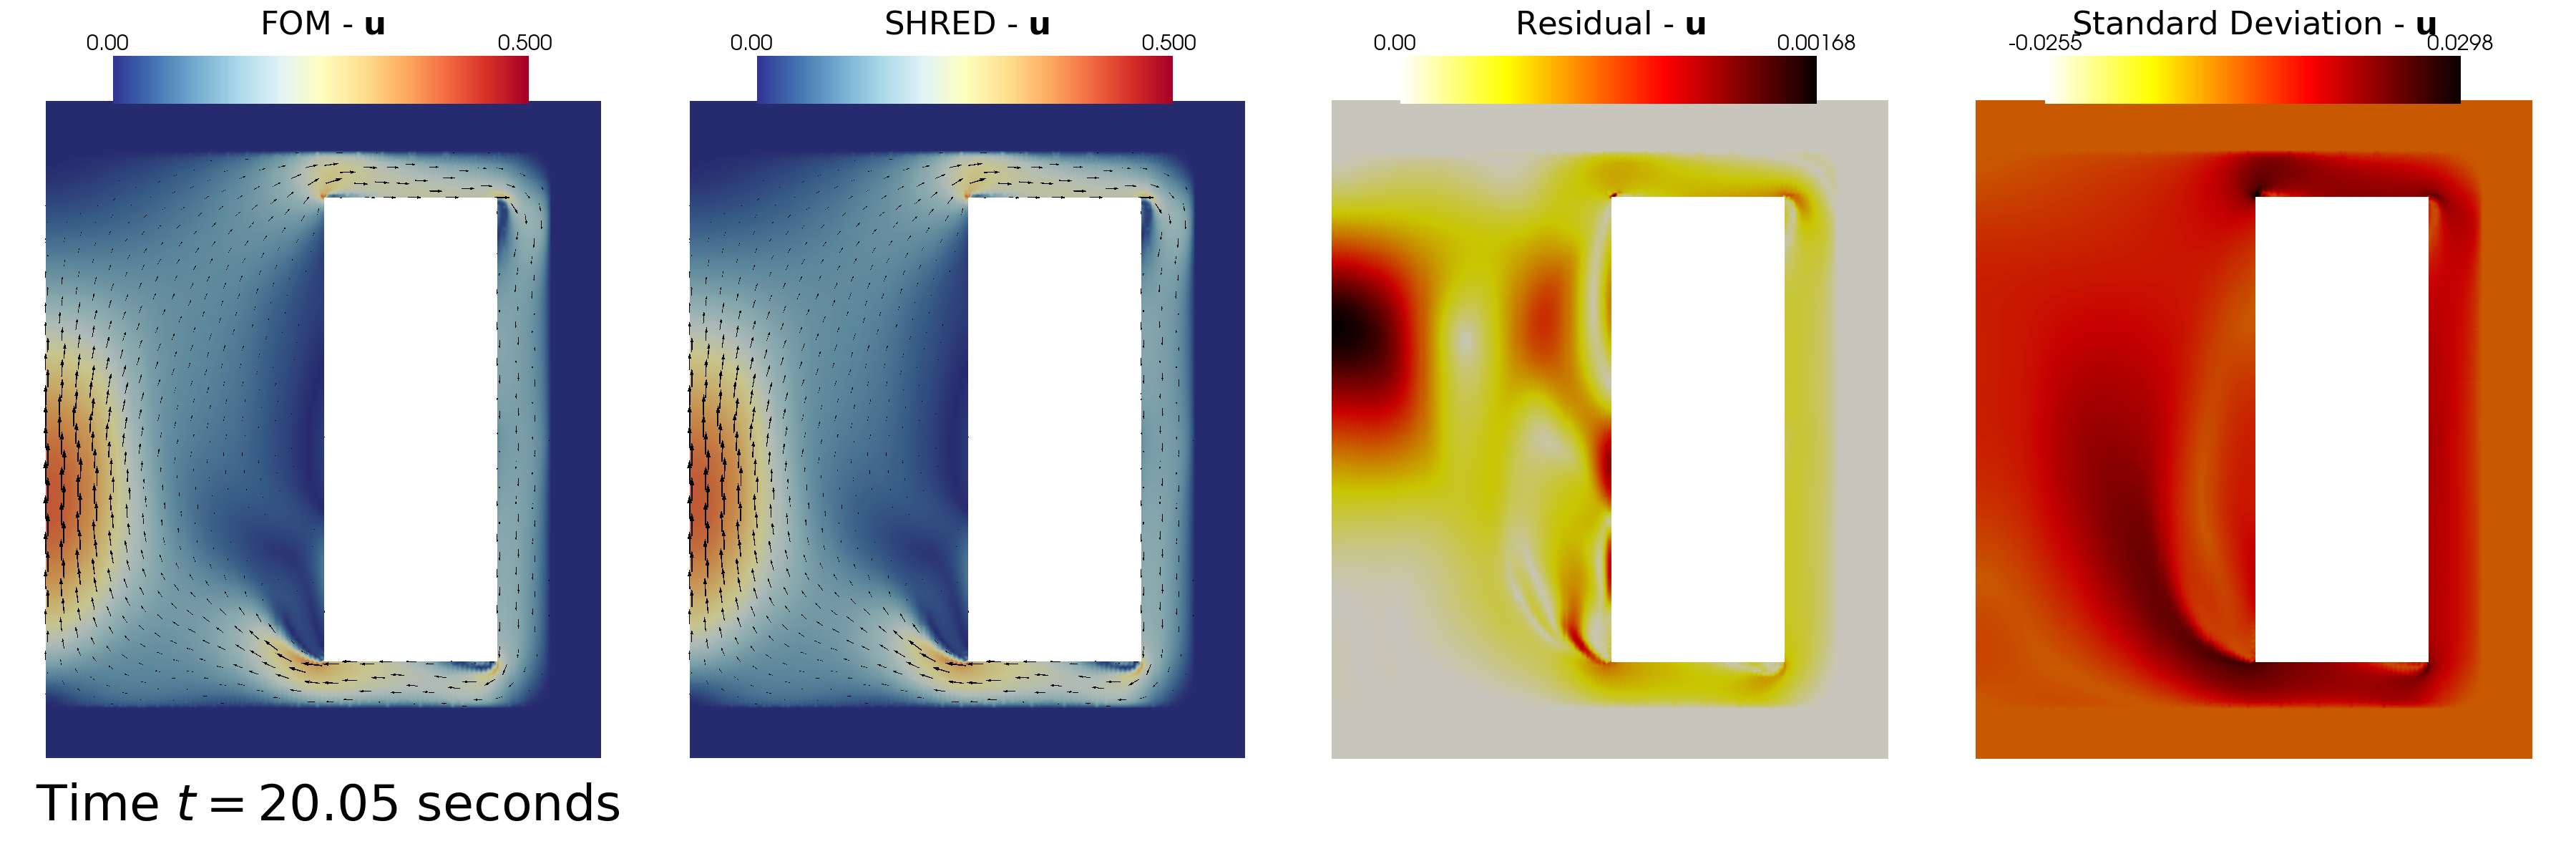

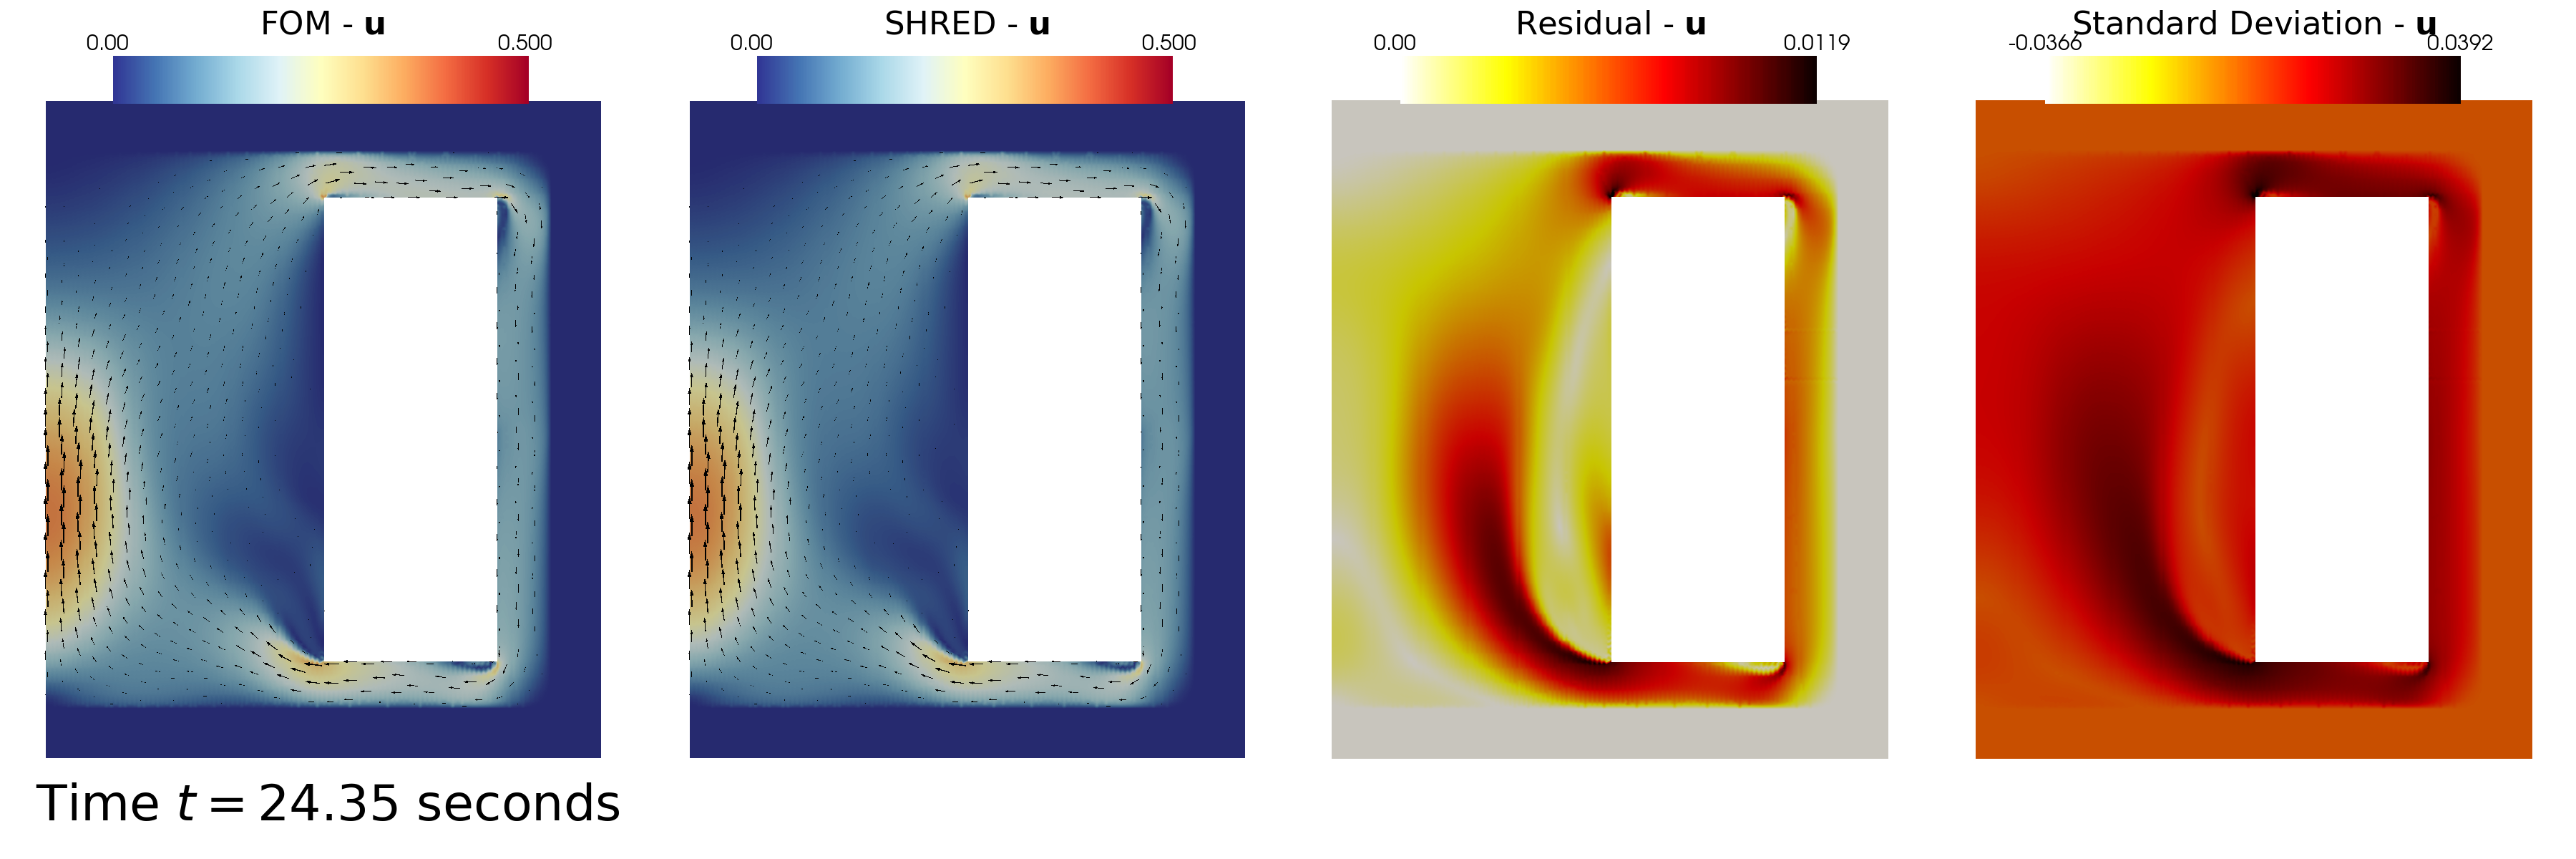

In [15]:
idxss_to_plot = [50, 100, 200, -1]
# idxss_to_plot = np.arange(0, len(fom_list), 5, dtype=int)

min_max_lims = [min(fom_list.return_matrix().flatten()), max(fom_list.return_matrix().flatten())]

for time_to_plot in idxss_to_plot:
    
    time = time_bins[time_to_plot]
    title = 'Time $t={:.2f}$ seconds'.format(time)
    
    if field_i == 0:
        # Flux 1
        clims = [1e16, 2.5e18]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    elif field_i == 1:
        # Flux 2
        clims = [1e16, 1e19]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    elif field_i == 2:
        # Flux 3
        clims = [1e16, 2e19]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    elif field_i == 3:
        # Flux 4
        clims = [1e16, 1e19]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    elif field_i == 4:
        # Flux 5
        clims = [1e16, 1e19]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    elif field_i == 5:
        # Flux 6
        clims = [1e16, 1e18]
        cmap = cm.magma
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
        
    elif field_i >= 6 and field_i < 14:
        # Precursors
        clims = min_max_lims
        cmap = cm.viridis
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
        
    elif field_i >= 14 and field_i < 17:
        # Decay Heat Groups
        clims = min_max_lims
        cmap = cm.inferno
        log_plot = False
        # tex = r'\log_{10}('+tex_var_names[field_i]+')'
    
    elif field_i == 17:
        # Temperature - T
        clims = [860, 1350]
        cmap = cm.jet
        log_plot = False
    elif field_i == 18:
        # Pressure - p
        clims = min_max_lims
        cmap = cm.bwr
        log_plot = False
    if field_i == 19:
        # Velocity - U 
        if time > 5:
            clims = [0,0.5]
        else:
            clims = [0, 1.5]
        cmap = cm.RdYlBu_r
        log_plot = False
        
    # clims = None
    # cmap = cm.rainbow
        
    Plot_SHRED_std_reconstruction(  fom_list, pred_list, std_pred_list, 
                                    tex_var_names[field_i], time_to_plot=time_to_plot, title=title,
                                    # filename=path_fig+var_names[field_i]+'_time_{:.2f}'.format(time), 
                                    filename = None, 
                                    colormaps = cmap,
                                    # clims = None,
                                    clims = clims,
                                    colormaps_residual = cm.hot_r
                                    )